In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import scipy.stats

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [4]:
def load_subject(subject, data_directory):
    file_suffix = 'cells'
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [5]:
# NB: Run only if file does not exist or needs to be regenerated
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject,
#                                                                                                data_directory=data_directory), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_PISA.npy', dict_results_across_mice)

In [6]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA.npy', 
                                   allow_pickle=True).item()
# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+'_'+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12_noshock']
subjects = list(dict_results_across_mice.keys())


In [7]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['noshock','demonstrator', 'observer'])

In [8]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [157]:
df_noshock_ncells

area  BL13_noshock  BL1_noshock  BL20_noshock  \
0       Frontal pole cerebral cortex           350           14           174   
1                 Primary motor area         21711         1965          3425   
2               Secondary motor area         11421          995          2550   
3         Primary somatosensory area         44942         6615          3827   
4    Supplemental somatosensory area         12294         1990           821   
..                               ...           ...          ...           ...   
194    Interfascicular nucleus raphe           131          192            26   
195          Interpeduncular nucleus           599         1199           302   
196     Rostral linear nucleus raphe            11           80             0   
197     Central linear nucleus raphe           234          412           125   
198             Dorsal nucleus raphe            38          186             6   

     BL19_noshock  BL15_noshock  BL11_noshock  BL7_noshock  
0             149             5            93          144  
1            2001          1399          6538         8421  
2            2469          1487          3002         7168  
3            4167          2800         12870        16008  
4             656           724          1503         4770  
..            ...           ...           ...          ...  
194             0             9             3           30  
195             0            37            10          162  
196             0             0             0            3  
197             0            29            18          113  
198             0             2             0           36  

[198 rows x 8 columns]

# Calculate t-tests number of cell across groups per area

In [9]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups([df_noshock_ncells,
                                          df_demonstrator_ncells,
                                          df_observer_ncells],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])

In [10]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [11]:
#sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:20].set_index('area')

pval_noshock_vs_demonstrator
area                                                                 
Taenia tecta                                               0.00182447
Cortical amygdalar area                                    0.00217519
Piriform area                                              0.00279213
Anterior olfactory nucleus                                 0.00292756
Piriform-amygdalar area                                    0.00425337
Claustrum                                                  0.00590472
Posterolateral visual area                                 0.00614967
Anteromedial visual area                                   0.00734017
Primary visual area                                        0.00743611
Anterolateral visual area                                  0.00854139
Lateral visual area                                         0.0113864
Basomedial amygdalar nucleus                                0.0129476
Retrosplenial area                                          0.0137301
Intermediodorsal nucleus of the thalamus                    0.0153269
Dorsal peduncular area                                      0.0167086
Central medial nucleus of the thalamus                      0.0221668
Endopiriform nucleus                                        0.0253336
Intercalated amygdalar nucleus                              0.0258446
Rostrolateral visual area                                   0.0269892
Agranular insular area                                      0.0301568

In [12]:
#sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:30].set_index('area')

pval_noshock_vs_observer
area                                                                 
Dorsomedial nucleus of the hypothalamus                    1.2907e-05
Taenia tecta                                              0.000129376
Posterolateral visual area                                0.000324515
Basomedial amygdalar nucleus                              0.000758423
Cortical amygdalar area                                   0.000771821
Claustrum                                                   0.0010947
Retrosplenial area                                         0.00148809
Anterior olfactory nucleus                                 0.00155063
Piriform area                                              0.00168754
Primary visual area                                         0.0018229
Supramammillary nucleus                                    0.00219746
Piriform-amygdalar area                                    0.00275103
Parataenial nucleus                                        0.00303051
Lateral visual area                                        0.00374408
Dorsal premammillary nucleus                               0.00377843
Anterolateral visual area                                  0.00433938
Endopiriform nucleus                                       0.00597423
Anteromedial visual area                                   0.00699145
Rostrolateral visual area                                  0.00815396
Bed nucleus of the accessory olfactory tract               0.00927473
Medial amygdalar nucleus                                   0.00962675
Prelimbic area                                              0.0102272
Lateral hypothalamic area                                   0.0115341
Posterior hypothalamic nucleus                              0.0124582
Intercalated amygdalar nucleus                              0.0127296
Zona incerta                                                 0.012981
Ventral premammillary nucleus                               0.0130383
Lateral amygdalar nucleus                                   0.0132582
Nucleus of reuniens                                         0.0136276
Parastrial nucleus                                          0.0139514

In [13]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:10].set_index('area')

pval_demonstrator_vs_observer
area                                                                            
Septohippocampal nucleus                                               0.0914872
Preparasubthalamic nucleus                                              0.113437
Midbrain reticular nucleus retrorubral area                             0.121839
Globus pallidus internal segment                                        0.129722
Intermediodorsal nucleus of the thalamus                                0.142857
Retrosplenial area                                                      0.151254
Periventricular hypothalamic nucleus preoptic part                      0.159605
Primary visual area                                                     0.179391
Lateral habenula                                                        0.190229
Pedunculopontine nucleus                                                0.192417

# Correlations across number of cells

In [14]:
corr_matrix_noshock_ncells = ace.cross_corr(df_noshock_ncells)
corr_matrix_demonstrator_ncells = ace.cross_corr(df_demonstrator_ncells)
corr_matrix_observer_ncells = ace.cross_corr(df_observer_ncells)

Text(0.5, 1.0, 'OBSERVER')

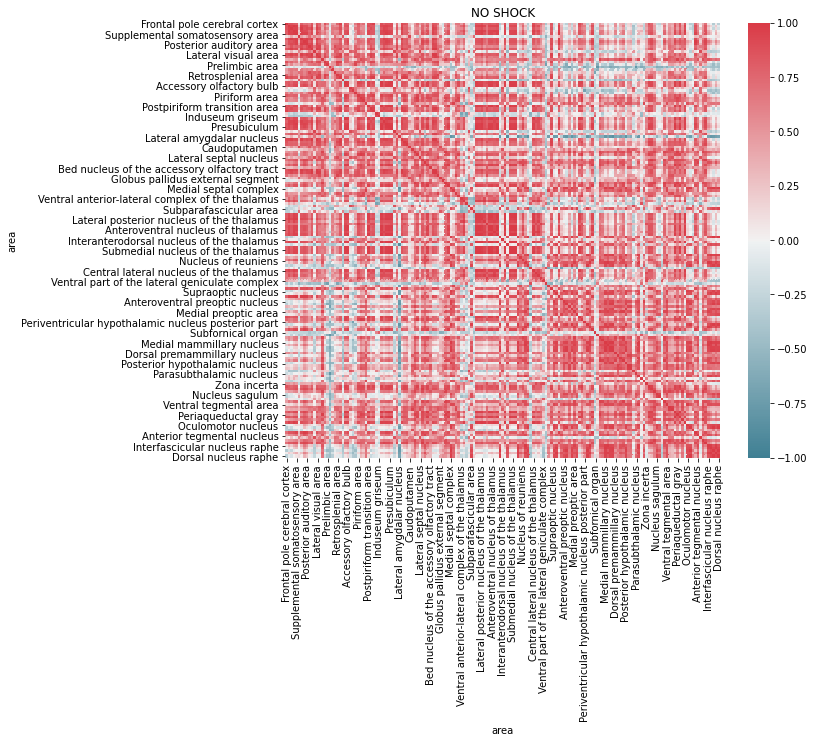

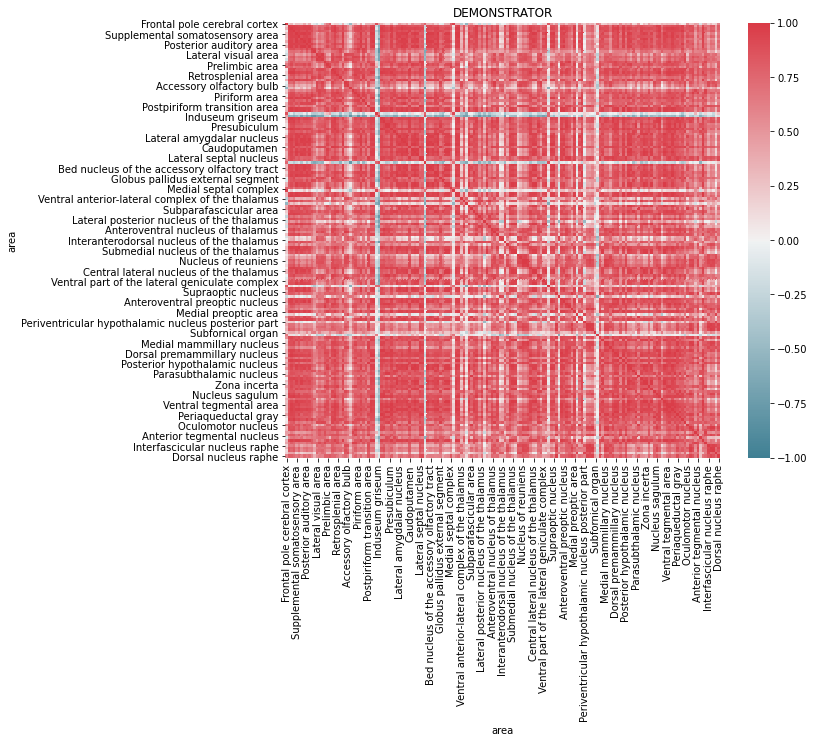

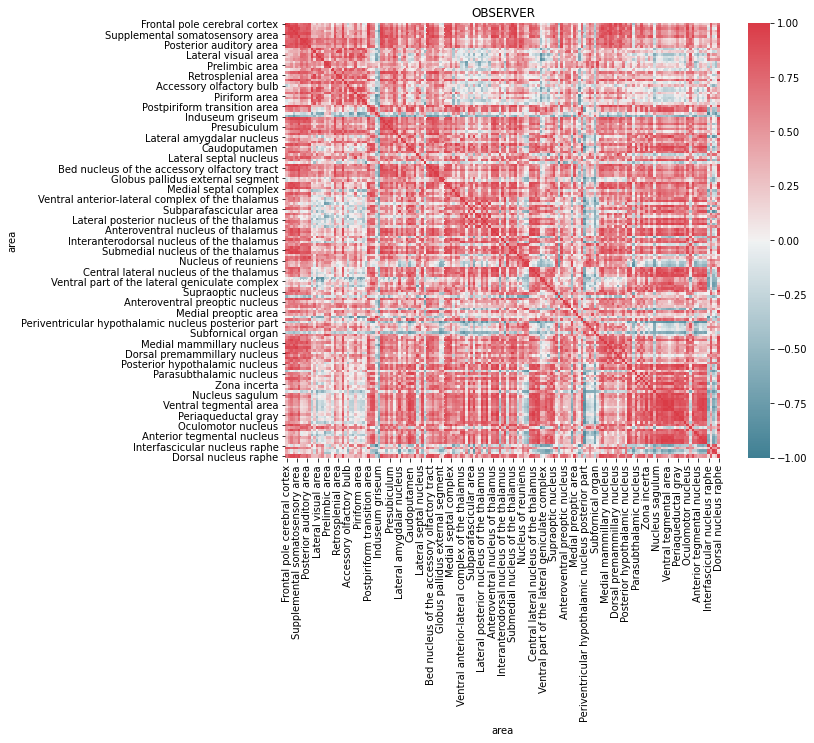

In [15]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Calculate t-tests density across groups per area

In [16]:
df_noshock_density, df_demonstrator_density, df_observer_density = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='density')
df_ttest_density = ace.test_across_groups([df_noshock_density,
                                          df_demonstrator_density,
                                          df_observer_density],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_density = df_ttest_density.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

# Calculate t-tests energy across groups per area

In [17]:
df_noshock_energy, df_demonstrator_energy, df_observer_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')
df_ttest_energy = ace.test_across_groups([df_noshock_energy,
                                          df_demonstrator_energy,
                                          df_observer_energy],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])


In [18]:
df_ttest_not_null_energy.sort_values(
    by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:20].set_index('area')

pval_noshock_vs_demonstrator
area                                                                  
Nucleus of reuniens                                          0.0136958
Postpiriform transition area                                 0.0174121
Rhomboid nucleus                                             0.0201523
Anterior olfactory nucleus                                   0.0245927
Taenia tecta                                                 0.0261416
Parataenial nucleus                                          0.0279009
Cortical amygdalar area                                      0.0379298
Piriform area                                                0.0384973
Lateral visual area                                          0.0391958
Central medial nucleus of the thalamus                       0.0402561
Claustrum                                                    0.0436815
Posterolateral visual area                                    0.043883
Main olfactory bulb                                          0.0528014
Intermediodorsal nucleus of the thalamus                      0.056224
Primary visual area                                          0.0586529
Interanteromedial nucleus of the thalamus                    0.0612817
Entorhinal area                                              0.0625716
Retrosplenial area                                           0.0627783
Subparafascicular area                                       0.0639262
Dorsomedial nucleus of the hypothalamus                      0.0658809

In [19]:
df_ttest_not_null_energy.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:45].set_index('area')

pval_noshock_vs_observer
area                                                                     
Piriform area                                                  0.00252548
Posterolateral visual area                                     0.00287451
Anterior olfactory nucleus                                     0.00381209
Cortical amygdalar area                                        0.00566318
Claustrum                                                      0.00607823
Primary visual area                                            0.00837663
Basomedial amygdalar nucleus                                   0.00878435
Supramammillary nucleus                                         0.0102367
Anterolateral visual area                                       0.0103215
Lateral visual area                                             0.0112924
Dorsomedial nucleus of the hypothalamus                         0.0123105
Orbital area                                                    0.0225208
Dorsal premammillary nucleus                                    0.0242529
Superior colliculus motor related                               0.0256507
Bed nucleus of the anterior commissure                          0.0269636
Parataenial nucleus                                             0.0279161
Main olfactory bulb                                             0.0279506
Entorhinal area                                                 0.0279893
Subiculum                                                       0.0310964
Ventral medial nucleus of the thalamus                          0.0313624
Endopiriform nucleus                                            0.0334889
Basolateral amygdalar nucleus                                    0.033995
Parastrial nucleus                                              0.0355229
Zona incerta                                                    0.0360066
Anteromedial visual area                                        0.0366255
Retrosplenial area                                               0.036639
Accessory olfactory bulb                                        0.0377177
Nucleus of reuniens                                             0.0379496
Subparafascicular nucleus                                       0.0392362
Ventral posterior complex of the thalamus                       0.0397015
Lateral amygdalar nucleus                                       0.0402672
Lateral habenula                                                0.0406612
Ventral anterior-lateral complex of the thalamus                0.0407844
Taenia tecta                                                    0.0408351
Reticular nucleus of the thalamus                                0.041286
Pretectal region                                                0.0443618
Subgeniculate nucleus                                           0.0451921
Postsubiculum                                                   0.0468278
Anterior hypothalamic nucleus                                    0.047447
Posterior limiting nucleus of the thalamus                      0.0477804
Superior colliculus sensory related                             0.0490884
Interanteromedial nucleus of the thalamus                        0.051163
Lateral dorsal nucleus of thalamus                               0.051374
Posterior auditory area                                         0.0525484
Piriform-amygdalar area                                         0.0529529

In [20]:
df_ttest_not_null_energy.sort_values(
    by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:10].set_index('area')

pval_demonstrator_vs_observer
area                                                                     
Midbrain reticular nucleus retrorubral area                       0.14719
Pedunculopontine nucleus                                         0.186792
Intermediodorsal nucleus of the thalamus                         0.186932
Red nucleus                                                      0.189055
Globus pallidus internal segment                                 0.214984
Anterior tegmental nucleus                                       0.232238
Anteroventral nucleus of thalamus                                0.232985
Tuberal nucleus                                                  0.234142
Bed nucleus of the anterior commissure                           0.234549
Medial septal complex                                            0.235484

In [21]:
corr_matrix_noshock_energy = ace.cross_corr(df_noshock_energy)
corr_matrix_demonstrator_energy = ace.cross_corr(df_demonstrator_energy)
corr_matrix_observer_energy = ace.cross_corr(df_observer_energy)

Text(0.5, 1.0, 'OBSERVER')

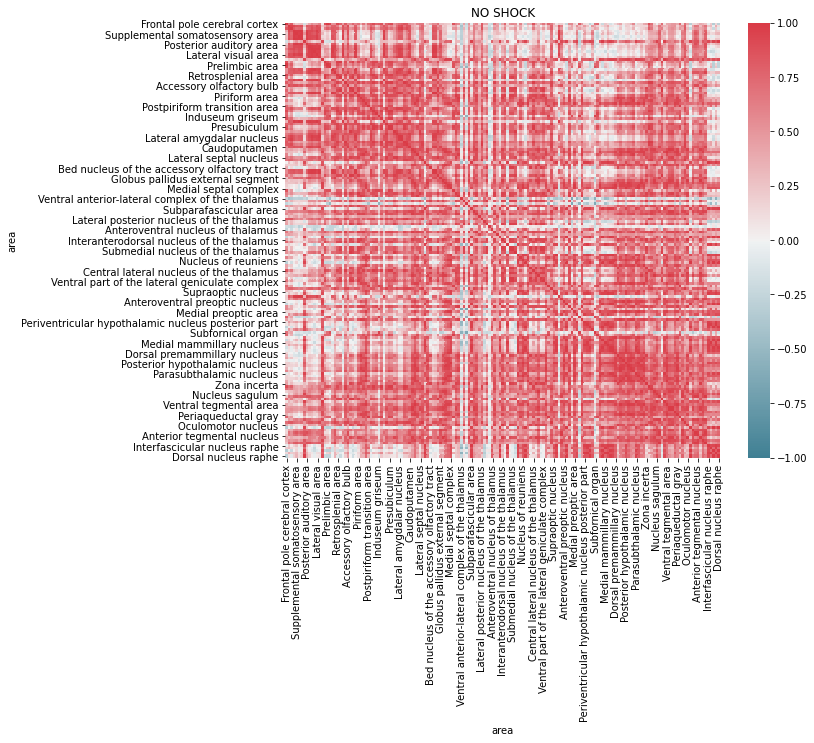

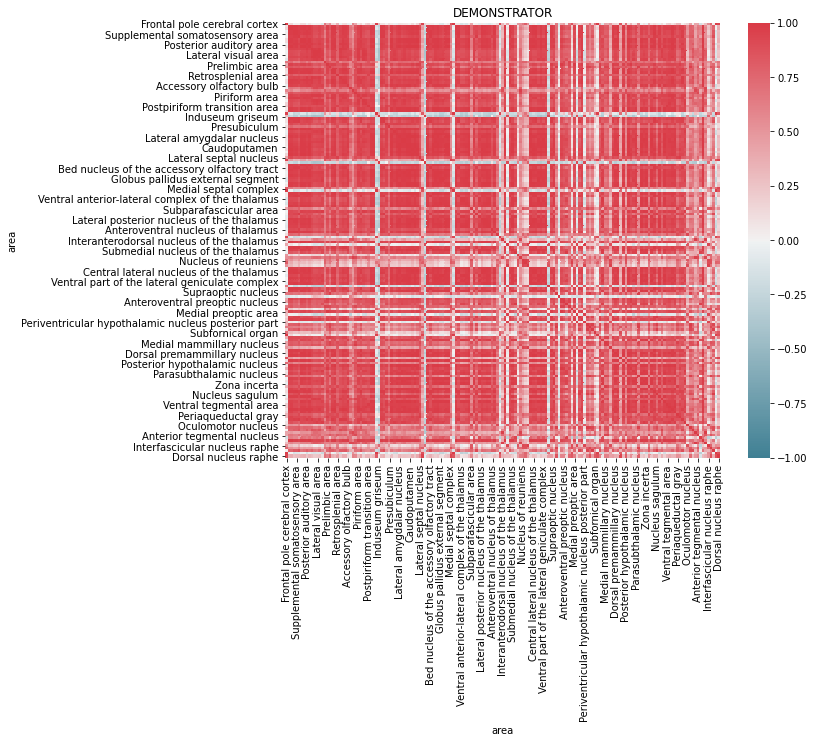

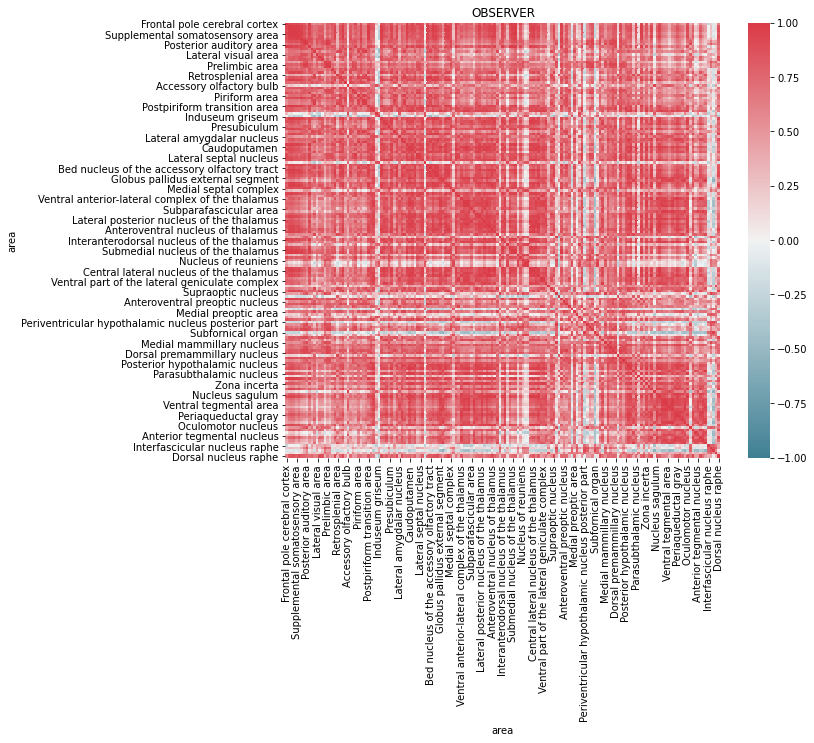

In [22]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Calculate relative density

In [23]:
df_noshock_rd, df_demonstrator_rd, df_observer_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')
df_ttest_rd = ace.test_across_groups([df_noshock_rd,
                                          df_demonstrator_rd,
                                          df_observer_rd],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [24]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:30].set_index('area')

pval_noshock_vs_demonstrator
area                                                                           
Midbrain reticular nucleus retrorubral area                         0.000629013
Cortical amygdalar area                                             0.000887821
Piriform area                                                        0.00116855
Posterolateral visual area                                           0.00132935
Red nucleus                                                          0.00138495
Caudoputamen                                                          0.0035865
Entorhinal area                                                       0.0038007
Lateral visual area                                                  0.00387188
Globus pallidus external segment                                     0.00532057
Endopiriform nucleus                                                 0.00600785
Basomedial amygdalar nucleus                                         0.00613235
Primary visual area                                                  0.00620921
Substantia nigra compact part                                        0.00646081
Pedunculopontine nucleus                                             0.00725362
Anterolateral visual area                                              0.012152
Peripeduncular nucleus                                                 0.014133
Main olfactory bulb                                                    0.016186
Claustrum                                                             0.0200859
Intercalated amygdalar nucleus                                         0.020781
Anterior olfactory nucleus                                            0.0259983
Nucleus of reuniens                                                   0.0270409
Lateral terminal nucleus of the accessory optic...                    0.0290265
Taenia tecta                                                           0.029147
Substantia nigra reticular part                                       0.0335405
Fundus of striatum                                                    0.0341626
Nucleus of the lateral olfactory tract                                0.0350948
Rhomboid nucleus                                                      0.0471667
Globus pallidus internal segment                                      0.0507344
Posterior auditory area                                               0.0536221
Midbrain reticular nucleus                                            0.0594599

In [25]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:20].set_index('area')

pval_noshock_vs_observer
area                                                     
Primary visual area                            0.00175631
Posterolateral visual area                     0.00307767
Caudoputamen                                   0.00362568
Entorhinal area                                0.00454839
Anterior olfactory nucleus                     0.00762707
Piriform area                                  0.00847412
Lateral visual area                             0.0110072
Endopiriform nucleus                            0.0112166
Cortical amygdalar area                         0.0114662
Anterolateral visual area                       0.0144402
Retrosplenial area                              0.0175213
Anteromedial visual area                        0.0219774
Red nucleus                                     0.0252056
Basomedial amygdalar nucleus                    0.0329311
Pedunculopontine nucleus                        0.0446946
Primary motor area                              0.0462286
Claustrum                                       0.0505232
Globus pallidus external segment                0.0590306
Nucleus of reuniens                             0.0600156
Postsubiculum                                   0.0602134

In [26]:
df_ttest_not_null_rd.sort_values(
    by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:20].set_index('area')

pval_demonstrator_vs_observer
area                                                                            
Lateral hypothalamic area                                              0.0413796
Preparasubthalamic nucleus                                             0.0635891
Bed nucleus of the anterior commissure                                 0.0639482
Basolateral amygdalar nucleus                                          0.0668589
Globus pallidus internal segment                                       0.0921674
Globus pallidus external segment                                       0.0979381
Lateral habenula                                                       0.0993604
Postpiriform transition area                                            0.109447
Reticular nucleus of the thalamus                                       0.110022
Zona incerta                                                            0.115995
Primary motor area                                                      0.118002
Periventricular hypothalamic nucleus preoptic part                      0.118764
Midbrain reticular nucleus retrorubral area                             0.133676
Primary visual area                                                     0.134231
Intermediodorsal nucleus of the thalamus                                0.150143
Medial amygdalar nucleus                                                0.150762
Posterior limiting nucleus of the thalamus                              0.150968
Ventral auditory area                                                   0.173207
Dorsal peduncular area                                                   0.17832
Basomedial amygdalar nucleus                                            0.181469

In [27]:
corr_matrix_noshock_rd = ace.cross_corr(df_noshock_rd)
corr_matrix_demonstrator_rd = ace.cross_corr(df_demonstrator_rd)
corr_matrix_observer_rd = ace.cross_corr(df_observer_rd)

Text(0.5, 1.0, 'OBSERVER')

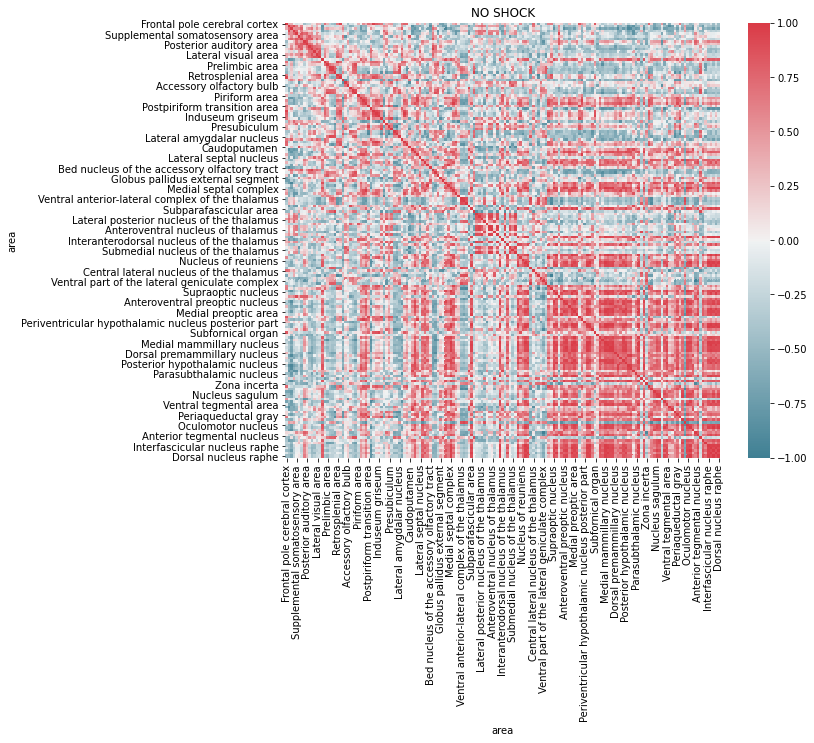

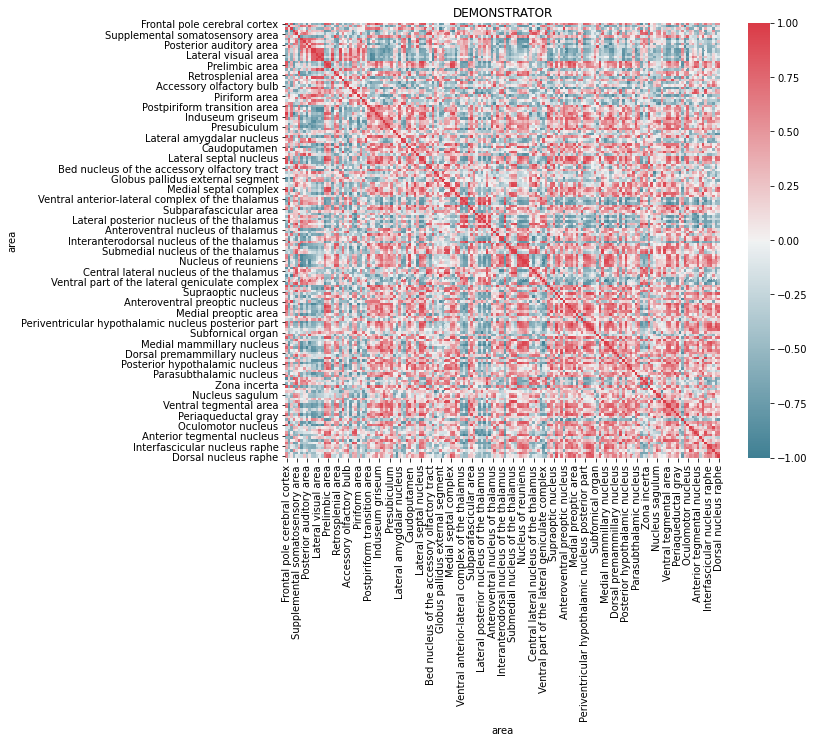

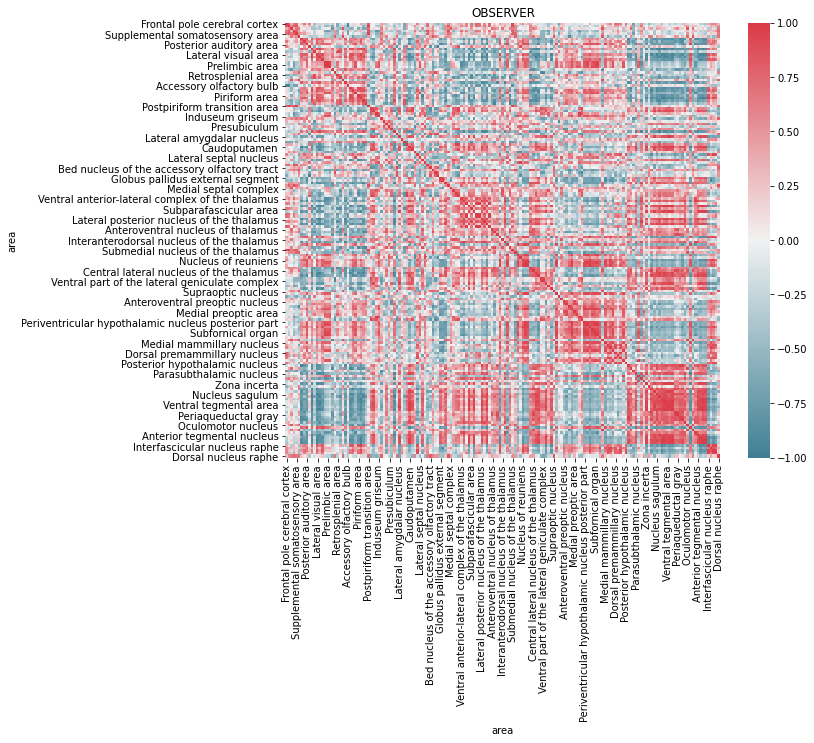

In [28]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Intersection of significant areas

In [108]:
areas_ncells = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms_ncells = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ncells])

In [109]:
areas_density = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms_density = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_density])

In [110]:
areas_energy = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms_energy = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_energy])

In [124]:
print(len(areas_ncells), len(areas_density), len(areas_energy))
print(len(areas_ttest_acronyms_ncells.intersection(areas_ttest_acronyms_density).intersection(areas_ttest_acronyms_energy)))
print(len(areas_ttest_acronyms_ncells.intersection(areas_ttest_acronyms_density).intersection(areas_ttest_acronyms_energy).intersection(areas_ttest_acronyms_rd)))

61 61 44
32
16


In [118]:
areas_pls = set(['LHA', 'MOB', 'SubG', 'BAC', 'PVpo', 'TT', 'RR', 'TR', 'LGv', 'VISpl', 'RT', 'AUDv', 'SI',
 'NB', 'COA', 'VISam', 'RN', 'AON', 'GPe', 'RCH', 'FS', 'VISal', 'CLA', 'RH', 'POL', 'SNc', 'PST', 'EP',
 'IA', 'ENT', 'BMA', 'ZI', 'RSP', 'CEA', 'MRN', 'LT', 'GPi', 'VISl', 'NLOT', 'RE', 'MOp', 'SNr', 'IAD',
 'CP', 'PPN', 'VISrl', 'OV', 'PMv', 'PIR', 'AUDpo', 'IAM', 'LH', 'VTA', 'PP', 'VISp'])
print(len(areas_pls))

55


In [122]:
areas_rd = np.unique(np.hstack([
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms_rd = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_rd])
len(areas_rd)

31

In [126]:
len(areas_pls.intersection(areas_ttest_acronyms_energy))

24

In [33]:
intersection_names = [volumes[volumes['acronym']==area]['safe_name'].values[0] for area in list(intersection)]
intersection_names

['Basomedial amygdalar nucleus',
 'Nucleus of reuniens',
 'Retrosplenial area',
 'Posterolateral visual area',
 'Pedunculopontine nucleus',
 'Primary motor area',
 'Substantia nigra reticular part',
 'Main olfactory bulb',
 'Taenia tecta',
 'Lateral hypothalamic area',
 'Fundus of striatum',
 'Piriform area',
 'Entorhinal area',
 'Endopiriform nucleus',
 'Globus pallidus external segment',
 'Lateral terminal nucleus of the accessory optic tract',
 'Anterolateral visual area',
 'Claustrum',
 'Lateral visual area',
 'Primary visual area',
 'Nucleus of the lateral olfactory tract',
 'Rhomboid nucleus',
 'Caudoputamen',
 'Anterior olfactory nucleus',
 'Midbrain reticular nucleus retrorubral area',
 'Intercalated amygdalar nucleus',
 'Substantia nigra compact part',
 'Peripeduncular nucleus',
 'Cortical amygdalar area',
 'Anteromedial visual area',
 'Red nucleus']

# Non parametric tests with correction

In [34]:
df_noshock_rd, df_demonstrator_rd, df_observer_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')
df_ttest_rd_np = ace.test_across_groups([df_noshock_rd,
                                          df_demonstrator_rd,
                                          df_observer_rd],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                     test = 'mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd_np = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [35]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:20].set_index('area')

pval_noshock_vs_observer
area                                                     
Primary visual area                            0.00175631
Posterolateral visual area                     0.00307767
Caudoputamen                                   0.00362568
Entorhinal area                                0.00454839
Anterior olfactory nucleus                     0.00762707
Piriform area                                  0.00847412
Lateral visual area                             0.0110072
Endopiriform nucleus                            0.0112166
Cortical amygdalar area                         0.0114662
Anterolateral visual area                       0.0144402
Retrosplenial area                              0.0175213
Anteromedial visual area                        0.0219774
Red nucleus                                     0.0252056
Basomedial amygdalar nucleus                    0.0329311
Pedunculopontine nucleus                        0.0446946
Primary motor area                              0.0462286
Claustrum                                       0.0505232
Globus pallidus external segment                0.0590306
Nucleus of reuniens                             0.0600156
Postsubiculum                                   0.0602134

In [36]:
df_ttest_not_null_rd_np.set_index('area')['pval_noshock_vs_demonstrator'][
    multipletests(df_ttest_not_null_rd_np['pval_noshock_vs_demonstrator'].values, 
                                          alpha=0.05, 
                                          method='fdr_bh',
                                          is_sorted=False, 
                                          returnsorted=False)[0]]

NameError: name 'multipletests' is not defined

In [ ]:
df_ttest_not_null_rd.set_index('area')['pval_demonstrator_vs_observer'][
    multipletests(df_ttest_not_null_rd['pval_demonstrator_vs_observer'].values, 
                                          alpha=0.05, 
                                          method='fdr_bh',
                                          is_sorted=False, 
                                          returnsorted=False)[0]]

# Correlation with behavior

In [37]:
#load behavioral data and removing mouse 12
behavior = pd.read_excel('/home/stella/Documents/Torino/projects/SexualImprinting/PISA/subs_FOS_EC.xlsx', 
                         index_col=0).drop(11)

In [38]:
behavior

cage label sex geno role  EC_amp_0  EC_lat_0          mouse
0   CLT_5   000   M   WT  NOS  1.055338      2.05   BL15_noshock
1   CLT_3   R00   M   WT  NOS -0.796098      3.00    BL7_noshock
2   CLT_3   0R0   M   WT  OBS  1.067573      2.40   BL2_observer
3   CLT_9   R00   F   WT  OBS  1.114847      1.70  BL21_observer
4   CLT_1   000   F   WT  OBS  3.932445      1.00   BL8_observer
5   CLT_7   00R   F   WT  OBS  9.881270      1.70  BL18_observer
6   CLT_2   0R0   F   WT  NOS -0.534185      1.20    BL1_noshock
7   CLT_7   000   F   WT  NOS  0.140642      2.05   BL19_noshock
8   CLT_6   0R0   M   WT  OBS  1.250897      2.80  BL10_observer
9   CLT_6   00B   M   WT  NOS  0.920259      1.15   BL11_noshock
10  CLT_2   000   F   WT  OBS  2.324617      1.40   BL5_observer
12  CLT_7   0R0   F   WT  NOS  1.150084      1.90   BL20_noshock
13  CLT_4   B00   M   WT  NOS -0.317816      1.10   BL13_noshock
14  CLT_5   0R0   M   WT  OBS  1.573428      2.05  BL16_observer

In [39]:
behavior_noshock = behavior[behavior['role'] == 'NOS'][['EC_amp_0', 'EC_lat_0']]
behavior_observer = behavior[behavior['role'] == 'OBS'][['EC_amp_0', 'EC_lat_0']]

In [40]:
plt.subplots_adjust?

<AxesSubplot:xlabel='geno', ylabel='EC_lat_0'>

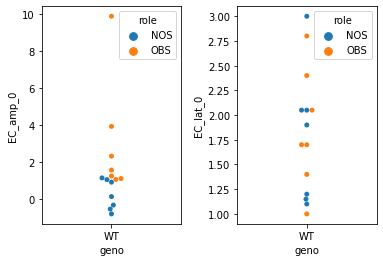

In [41]:
# make plot
fig, axes = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4)
# Draw a categorical scatterplot to show each observation
sns.swarmplot(data=behavior, y="EC_amp_0",x='geno',
                   hue="role", ax=axes[0])
sns.swarmplot(data=behavior, y="EC_lat_0",x='geno',
                   hue="role", ax=axes[1])

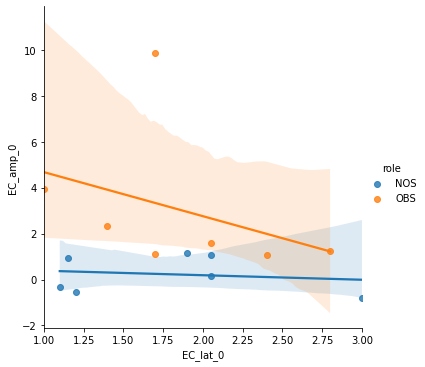

In [42]:
g = sns.lmplot(
    data=behavior,
    x="EC_lat_0", y="EC_amp_0", hue="role",
    height=5
)

# Plots corr tests

In [43]:
areas_ttest_ncells = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest_ncells])

/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

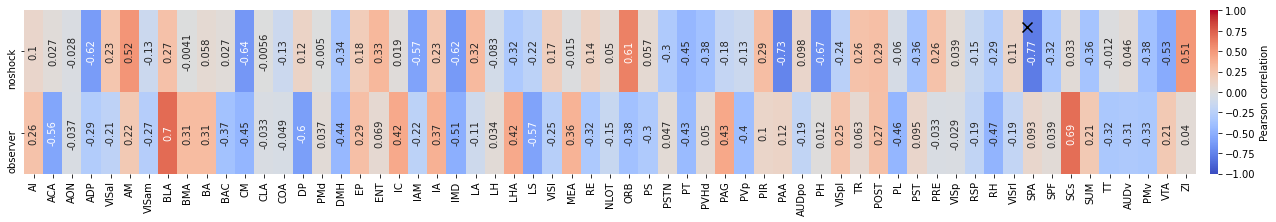

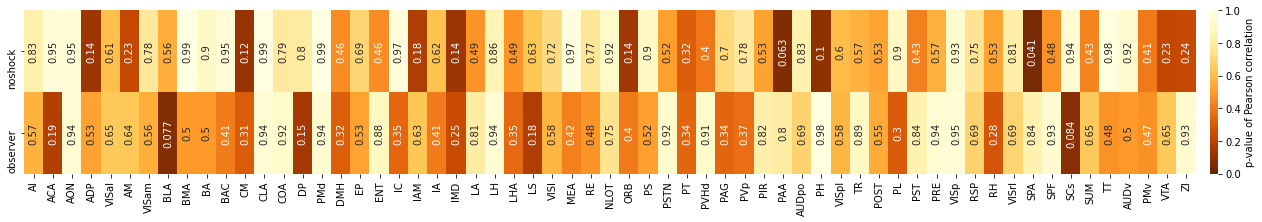

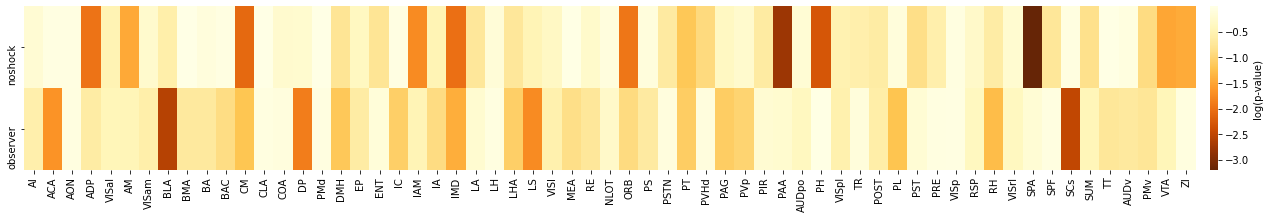

In [44]:
significant_areas = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest_ncells]
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_ncells, df_observer_ncells], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_amp_0'],
                                                      behavior_observer['EC_amp_0']],
                                   significant_areas=significant_areas)
# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr_ncells, ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})
axes.scatter(*np.argwhere(pvalue.values.T < 0.05).T+0.2, marker="x", 
             color="black", s=100)
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(pvalue, ax=axes, cmap="YlOrBr_r", vmin=0, vmax=+1, 
                             cbar_kws={'label': 'p-value of Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(np.log(pvalue), ax=axes, cmap="YlOrBr_r", 
                             cbar_kws={'label': 'log(p-value)',"pad":0.01})

# TODO: check delta tra correlazioni nei gruppi + distribuzioni correlazioni tra gruppi

Text(0.5, 1.0, 'Observer')

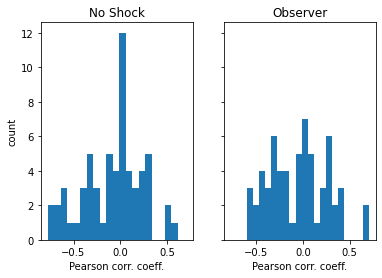

In [45]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].hist(corr_ncells.T['noshock'], bins=20)
axes[1].hist(corr_ncells.T['observer'], bins=20)
axes[0].set_ylabel('count')
axes[0].set_xlabel('Pearson corr. coeff.')
axes[1].set_xlabel('Pearson corr. coeff.')
axes[0].set_title('No Shock')
axes[1].set_title('Observer')

# Try with all areas and select significant areas

/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

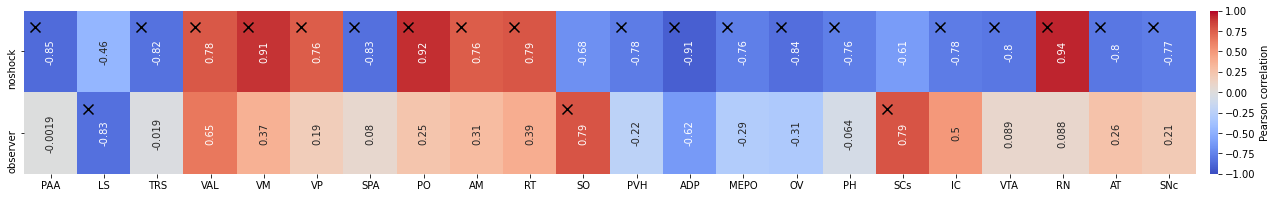

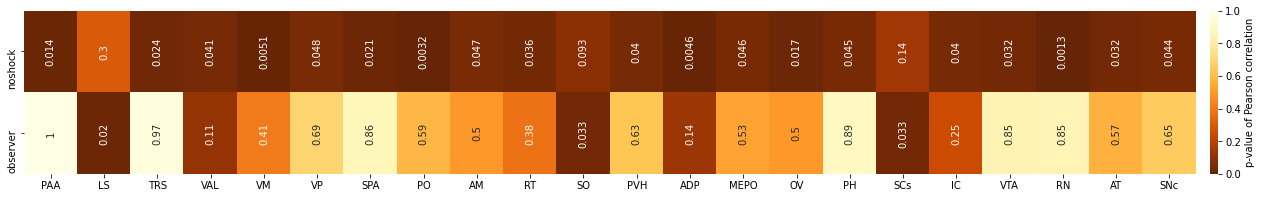

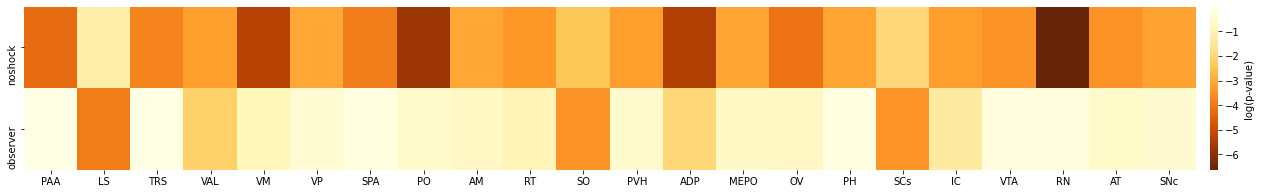

In [46]:
significant_areas = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
corr_rd, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_rd, df_observer_rd], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_amp_0'],
                                                      behavior_observer['EC_amp_0']])
significant_areas_correlation = list(pvalue[pvalue<0.05].dropna(how='all',axis=1).reset_index(drop=True).columns)

# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr_rd[significant_areas_correlation], ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})
axes.scatter(*np.argwhere(pvalue[significant_areas_correlation].values.T < 0.05).T+0.2, marker="x", 
             color="black", s=100)

fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(pvalue[significant_areas_correlation], ax=axes, cmap="YlOrBr_r", vmin=0, vmax=+1, 
                             cbar_kws={'label': 'p-value of Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(np.log(pvalue[significant_areas_correlation]), ax=axes, cmap="YlOrBr_r", 
                             cbar_kws={'label': 'log(p-value)',"pad":0.01})

# Areas PLS

/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

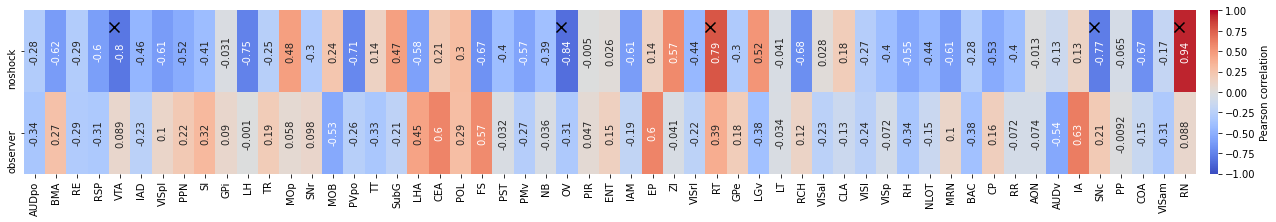

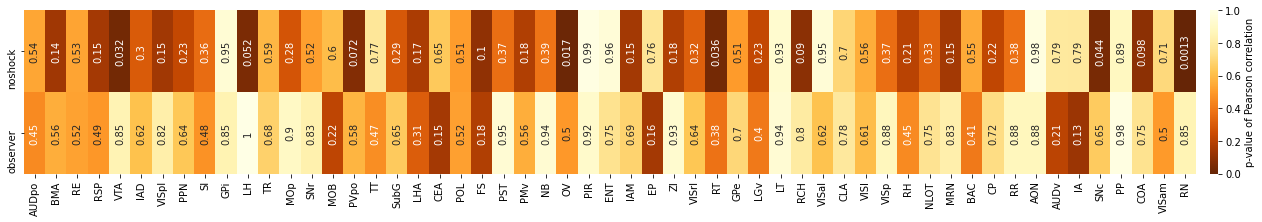

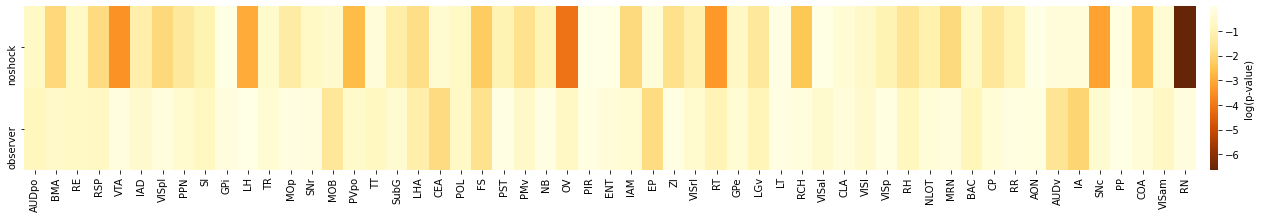

In [47]:
significant_areas = list(areas_pls)
corr, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_rd, df_observer_rd], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_amp_0'],
                                                      behavior_observer['EC_amp_0']],
                                   significant_areas=significant_areas)
# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr, ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})
axes.scatter(*np.argwhere(pvalue.values.T < 0.05).T+0.2, marker="x", 
             color="black", s=100)
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(pvalue, ax=axes, cmap="YlOrBr_r", vmin=0, vmax=+1, 
                             cbar_kws={'label': 'p-value of Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(np.log(pvalue), ax=axes, cmap="YlOrBr_r", 
                             cbar_kws={'label': 'log(p-value)',"pad":0.01})

# Plots correlation n_cells vs rel_density vs EC_amp_0

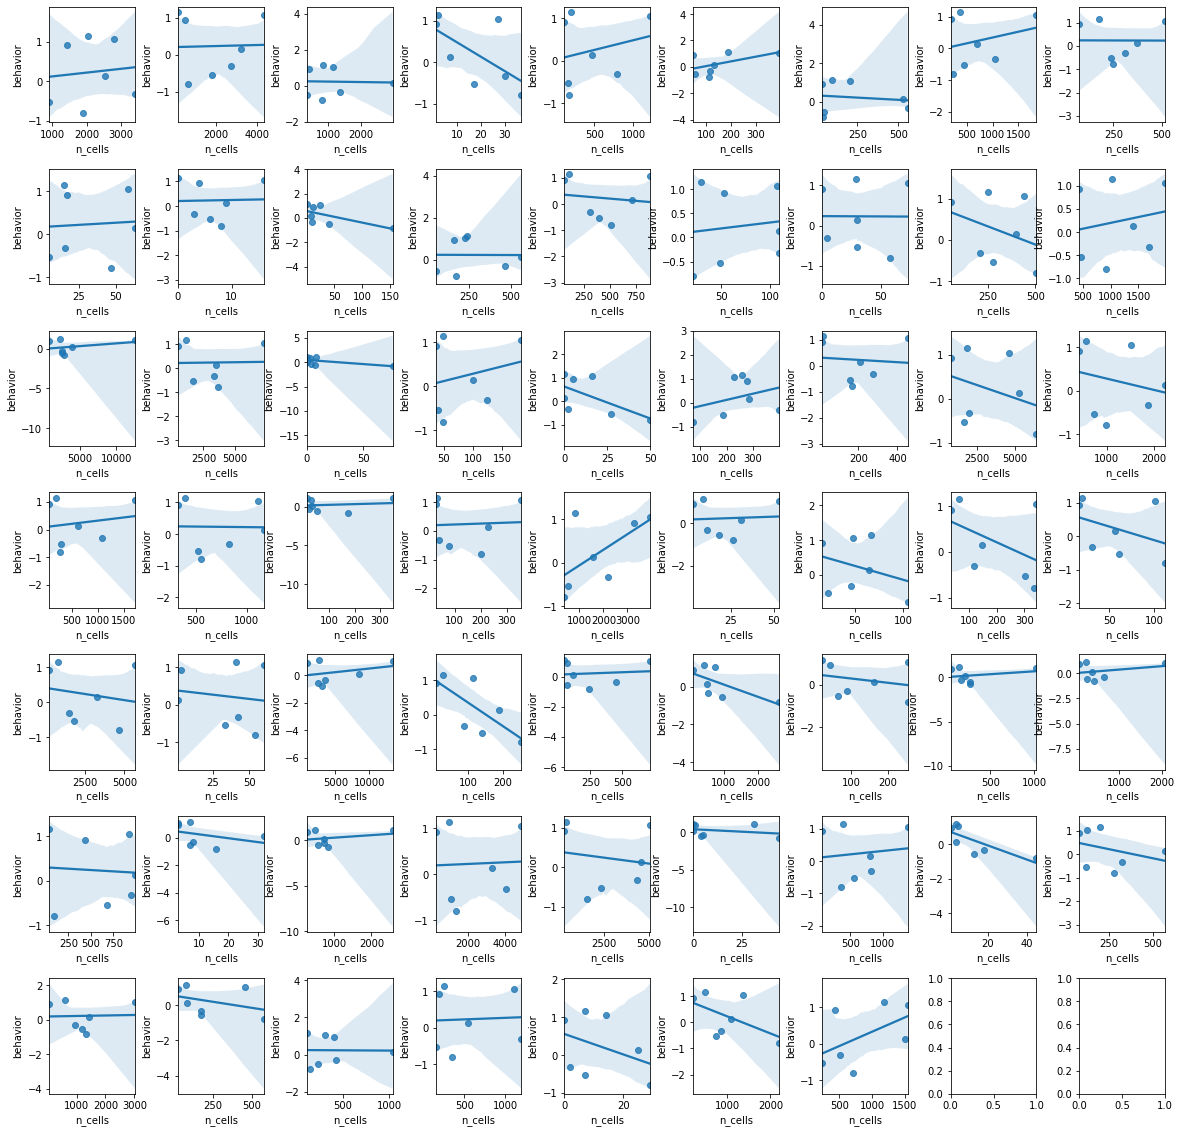

In [48]:
fig, axes  = plt.subplots(7,9, figsize=(20,20))
plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i, area in enumerate(areas_ttest_ncells):
    data = pd.DataFrame(columns=['n_cells', 'behavior'])
    data['n_cells'] = df_noshock_ncells.set_index('area').T[area].values
    data['behavior'] = behavior_noshock["EC_amp_0"].values
    g = sns.regplot(data=data, x='n_cells', 
                   y='behavior', ax=axes.flat[i])

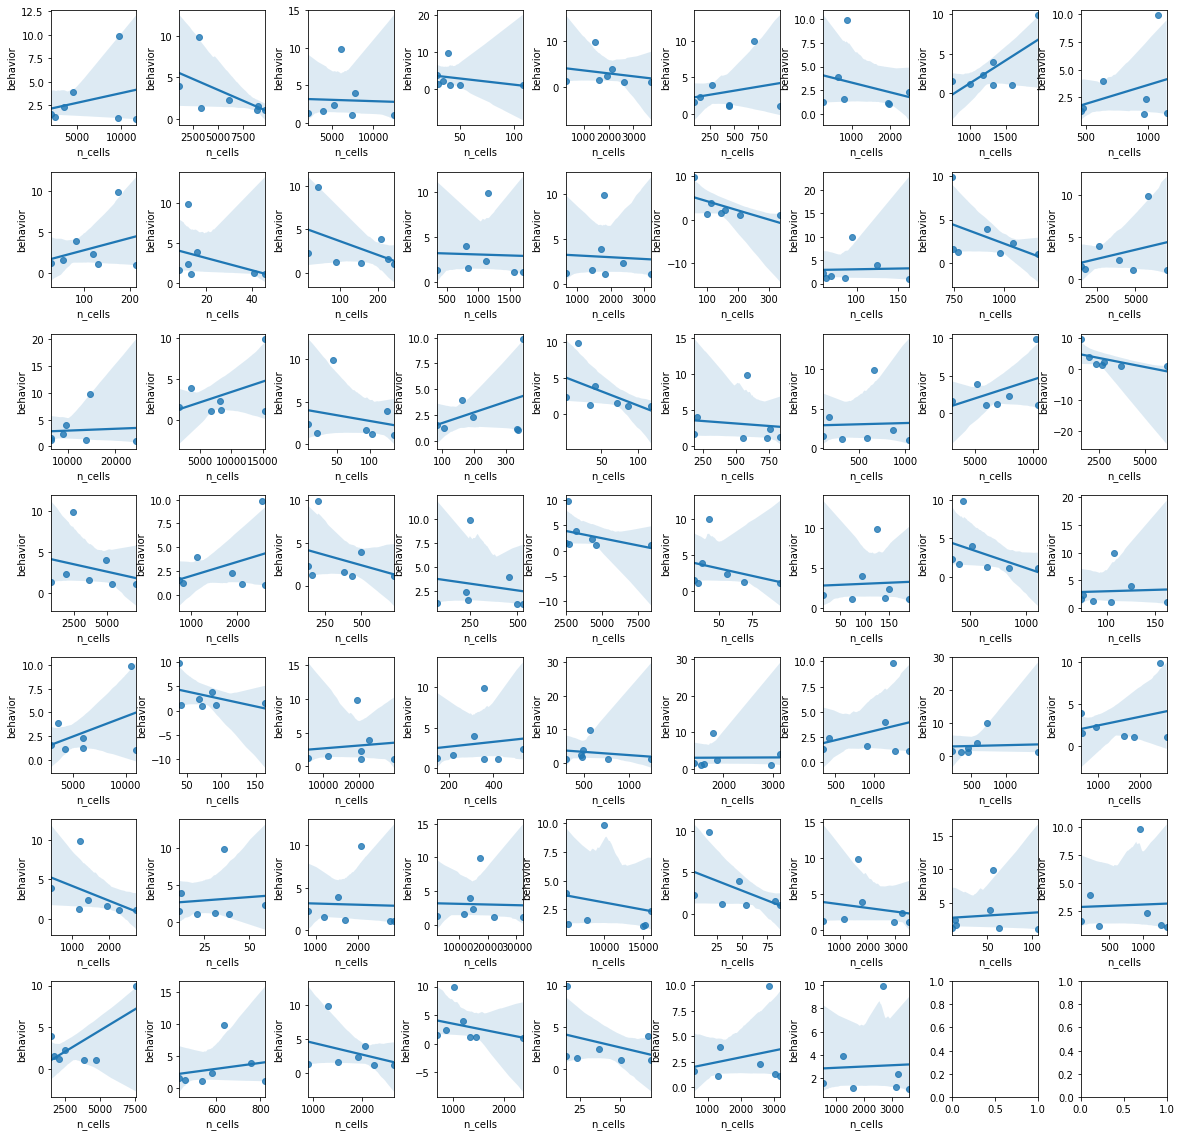

In [49]:
fig, axes  = plt.subplots(7,9, figsize=(20,20))
plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i, area in enumerate(areas_ttest_ncells):
    data = pd.DataFrame(columns=['n_cells', 'behavior'])
    data['n_cells'] = df_observer_ncells.set_index('area').T[area].values
    data['behavior'] = behavior_observer["EC_amp_0"].values
    g = sns.regplot(data=data, x='n_cells', 
                   y='behavior', ax=axes.flat[i])

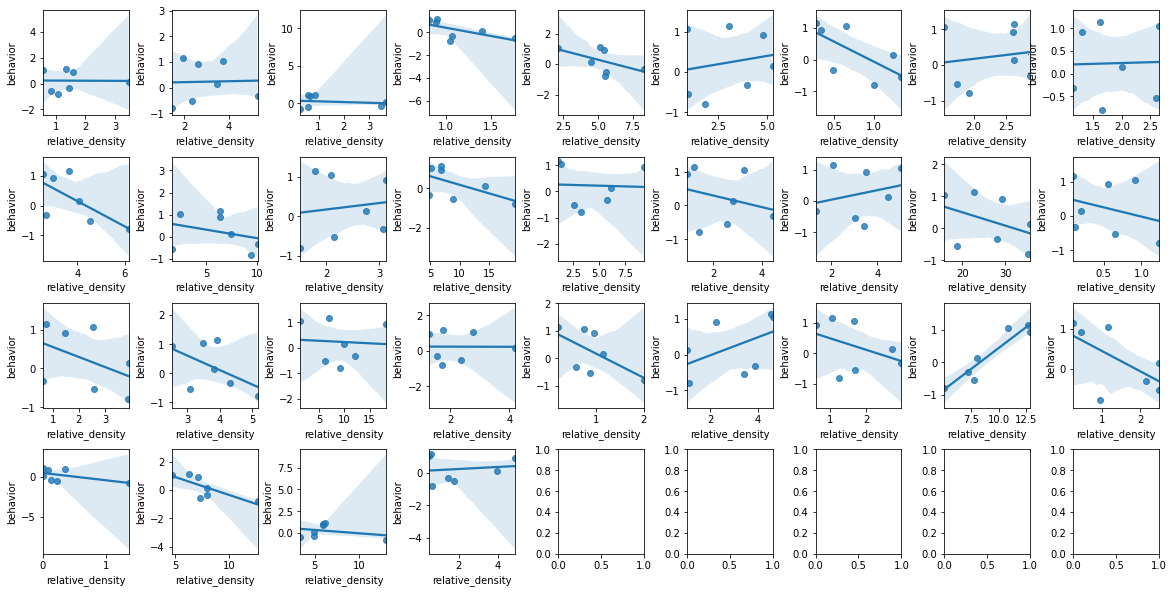

In [50]:
fig, axes  = plt.subplots(4,9, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i, area in enumerate(areas_ttest):
    data = pd.DataFrame(columns=['relative_density', 'behavior'])
    data['relative_density'] = df_noshock_rd.set_index('area').T[area].values
    data['behavior'] = behavior_noshock["EC_amp_0"].values
    g = sns.regplot(data=data, x='relative_density', 
                   y='behavior', ax=axes.flat[i])

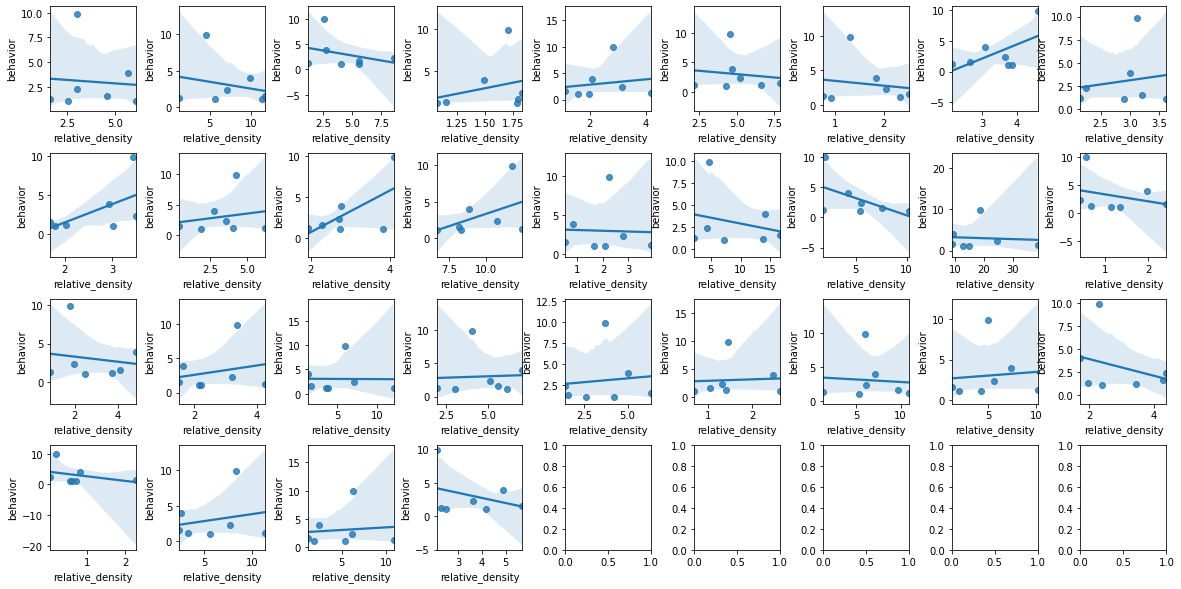

In [51]:
fig, axes  = plt.subplots(4,9, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i, area in enumerate(areas_ttest):
    data = pd.DataFrame(columns=['relative_density', 'behavior'])
    data['relative_density'] = df_observer_rd.set_index('area').T[area].values
    data['behavior'] = behavior_observer["EC_amp_0"].values
    g = sns.regplot(data=data, x='relative_density', 
                   y='behavior', ax=axes.flat[i])

#  Overlap aree attivate (noshock vs observer) vs (noshock vs demonstrator)

In [52]:
area_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values])
area_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values])

In [53]:
# intersection significant areas with relative density
area_noshock_vs_demonstrator.intersection(area_noshock_vs_observer) 

{'AON',
 'BMA',
 'COA',
 'CP',
 'ENT',
 'EP',
 'PIR',
 'PPN',
 'RN',
 'VISal',
 'VISl',
 'VISp',
 'VISpl'}

In [54]:
# areas that are significant in demonstrator but not in observer
area_noshock_vs_demonstrator.difference(area_noshock_vs_observer) 

{'CLA',
 'FS',
 'GPe',
 'IA',
 'LT',
 'MOB',
 'NLOT',
 'PP',
 'RE',
 'RH',
 'RR',
 'SNc',
 'SNr',
 'TT'}

In [55]:
# areas significant in observer and not in demonstrator
area_noshock_vs_observer.difference(area_noshock_vs_demonstrator) 

{'MOp', 'RSP', 'VISam'}

# Histograms

## relative density

<AxesSubplot:xlabel='area', ylabel='relative density'>

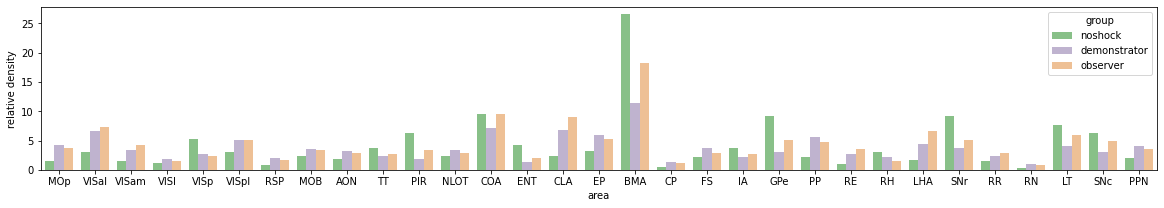

In [139]:
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'relative density', 'group'])
fam = pd.DataFrame(columns=['area', 'relative density', 'group'])
unfam = pd.DataFrame(columns=['area', 'relative density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['relative density'] = [df_noshock_rd.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['relative density'] = [df_demonstrator_rd.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['relative density'] = [df_observer_rd.set_index('area').loc[area].mean() for area in areas_ttest]
without_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'hspace':0.05}, figsize=(20,3))
sns.barplot(
    data=without_father,
    x="area", y="relative density", hue="group", palette="Accent", ax=ax)

## number of cells

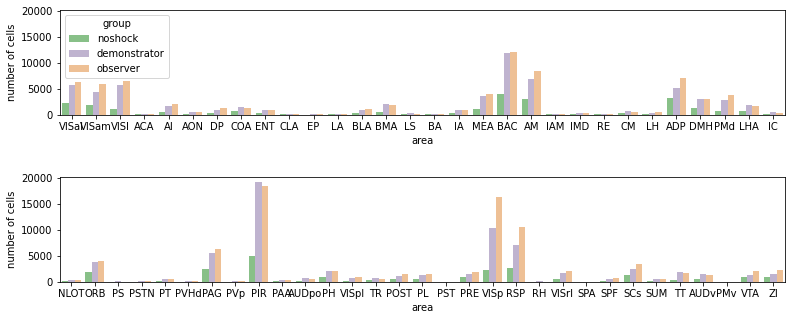

In [146]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:30]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))[30:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.6}, figsize=(13,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax[0])
sns.barplot(
    data=without_father2,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()

<AxesSubplot:xlabel='area', ylabel='number of cells'>

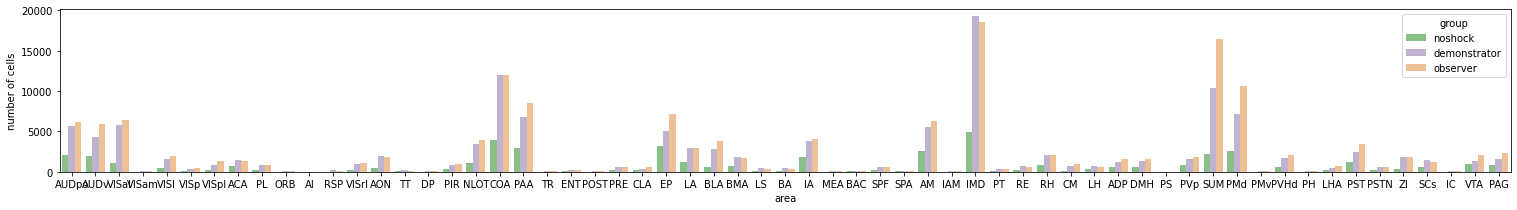

In [153]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(26,3), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

## density

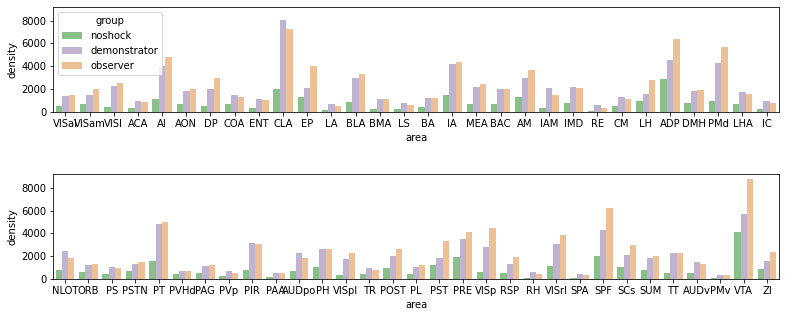

In [148]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:30]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))[30:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]


control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.6}, figsize=(13,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="density", hue="group", palette="Accent", ax=ax[0])
sns.barplot(
    data=without_father2,
    x="area", y="density", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()

<AxesSubplot:xlabel='area', ylabel='density'>

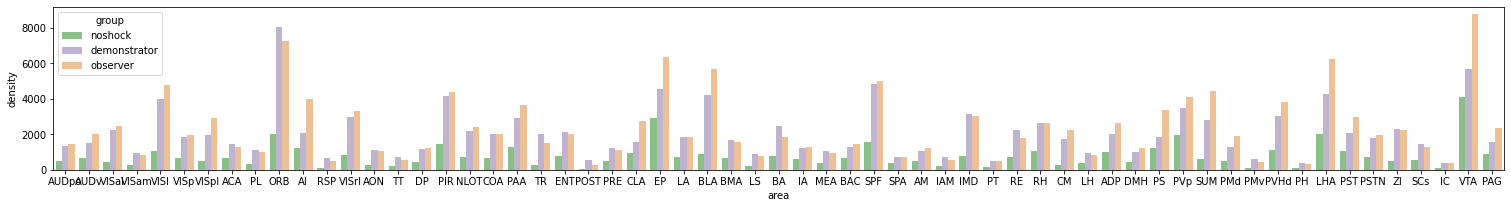

In [155]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(26,3), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="density", hue="group", palette="Accent", ax=ax)

## energy

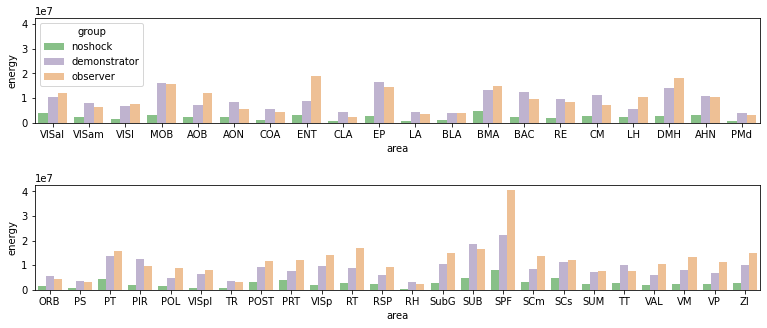

In [149]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:20]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))[20:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]


control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.6}, figsize=(13,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="energy", hue="group", palette="Accent", ax=ax[0])
sns.barplot(
    data=without_father2,
    x="area", y="energy", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()

<AxesSubplot:xlabel='area', ylabel='energy'>

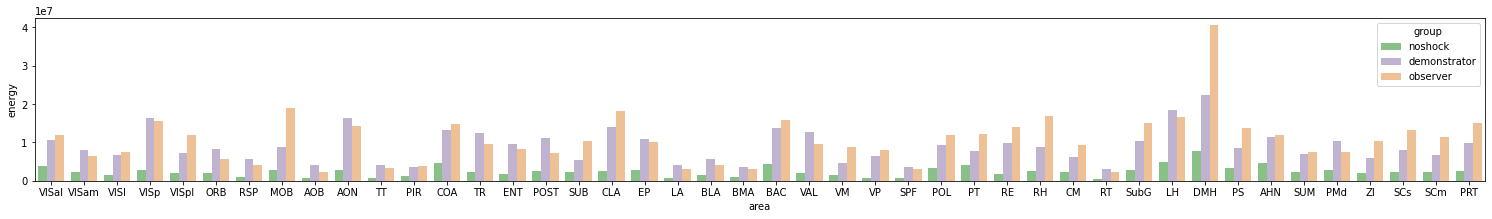

In [156]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(26,3), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

# Intersection significant areas (ttest ncells vs energy vs dens vs rel_dens) 
for 
- control vs observer 
- control vs demonstrator
- observer vs demonstrator

In [ ]:
ncells_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values])

energy_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values])

rd_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values])

density_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values])

print(len(ncells_noshock_vs_observer), len(energy_noshock_vs_observer), len(rd_noshock_vs_observer), len(density_noshock_vs_observer))
ncells_noshock_vs_observer.intersection(
    energy_noshock_vs_observer).intersection(
    rd_noshock_vs_observer).intersection(
    density_noshock_vs_observer)

In [ ]:
ncells_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values])

energy_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values])

rd_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values])

density_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values])

print(len(ncells_noshock_vs_demonstrator), len(energy_noshock_vs_demonstrator), len(rd_noshock_vs_demonstrator), len(density_noshock_vs_demonstrator))
ncells_noshock_vs_demonstrator.intersection(
    energy_noshock_vs_demonstrator).intersection(
    rd_noshock_vs_demonstrator).intersection(
    density_noshock_vs_demonstrator)

In [ ]:
ncells_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values])

energy_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values])

rd_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values])

density_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values])

print(len(ncells_demonstrator_vs_observer), len(energy_demonstrator_vs_observer), len(rd_demonstrator_vs_observer), len(density_demonstrator_vs_observer))
ncells_demonstrator_vs_observer.intersection(
    energy_demonstrator_vs_observer).intersection(
    rd_demonstrator_vs_observer).intersection(
    density_demonstrator_vs_observer)

# reorder areas

In [127]:
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]

In [128]:
areas_ttest

array(['Anterior olfactory nucleus', 'Anterolateral visual area',
       'Anteromedial visual area', 'Basomedial amygdalar nucleus',
       'Caudoputamen', 'Claustrum', 'Cortical amygdalar area',
       'Endopiriform nucleus', 'Entorhinal area', 'Fundus of striatum',
       'Globus pallidus external segment',
       'Intercalated amygdalar nucleus', 'Lateral hypothalamic area',
       'Lateral terminal nucleus of the accessory optic tract',
       'Lateral visual area', 'Main olfactory bulb',
       'Midbrain reticular nucleus retrorubral area',
       'Nucleus of reuniens', 'Nucleus of the lateral olfactory tract',
       'Pedunculopontine nucleus', 'Peripeduncular nucleus',
       'Piriform area', 'Posterolateral visual area',
       'Primary motor area', 'Primary visual area', 'Red nucleus',
       'Retrosplenial area', 'Rhomboid nucleus',
       'Substantia nigra compact part', 'Substantia nigra reticular part',
       'Taenia tecta'], dtype=object)

In [131]:
volumes['safe_name'].values

array(['root', 'Basic cell groups and regions', 'Cerebrum', ...,
       'parafloccular sulcus', 'Interpeduncular fossa', 'retina'],
      dtype=object)

In [136]:
new_areas = []
for area in volumes['safe_name'].values:
    if area in areas_ttest:
        new_areas.append(area)

In [138]:
[area for area in volumes['safe_name'].values if area in areas_ttest]

['Primary motor area',
 'Anterolateral visual area',
 'Anteromedial visual area',
 'Lateral visual area',
 'Primary visual area',
 'Posterolateral visual area',
 'Retrosplenial area',
 'Main olfactory bulb',
 'Anterior olfactory nucleus',
 'Taenia tecta',
 'Piriform area',
 'Nucleus of the lateral olfactory tract',
 'Cortical amygdalar area',
 'Entorhinal area',
 'Claustrum',
 'Endopiriform nucleus',
 'Basomedial amygdalar nucleus',
 'Caudoputamen',
 'Fundus of striatum',
 'Intercalated amygdalar nucleus',
 'Globus pallidus external segment',
 'Peripeduncular nucleus',
 'Nucleus of reuniens',
 'Rhomboid nucleus',
 'Lateral hypothalamic area',
 'Substantia nigra reticular part',
 'Midbrain reticular nucleus retrorubral area',
 'Red nucleus',
 'Lateral terminal nucleus of the accessory optic tract',
 'Substantia nigra compact part',
 'Pedunculopontine nucleus']